# Python CNN - Safari

This notebook is similar to the 'Python CNN - Classifying Shapes' notebook, except we will use transfer learning. The dataset used here was obtained via the 'Create Machine Learning Models in Microsoft Azure Course' on Coursera.

First we will explore the data by plotting the images and examining their size.

4 classes:
['elephant', 'giraffe', 'lion', 'zebra']


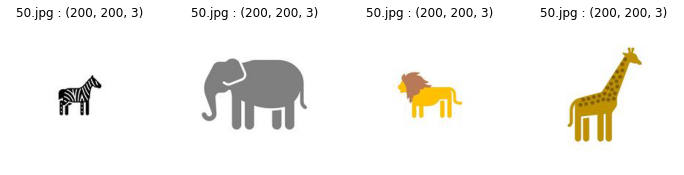

In [21]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

#Load in the images
data_path = 'data/safari/training'

#Get the class names
classes = os.listdir(data_path)
classes.sort()
print(len(classes), 'classes:')
print(classes)

# Show the first image in each folder
fig = plt.figure(figsize=(12, 12))
i = 0
for sub_dir in os.listdir(data_path):
    i+=1
    img_file = os.listdir(os.path.join(data_path,sub_dir))[0]
    img_path = os.path.join(data_path, sub_dir, img_file)
    img = mpimg.imread(img_path)
    img_shape = np.array(img).shape
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file + ' : ' + str(img_shape))
plt.show()

## Load a Pre-Trained Model

We will use one of the pre-trained classification models available via torchvision. We will ensure that the feature extraction layers are set to read only so that these are not re-trained, and change the size of the output layer to match the number of classes in our dataset.

In [22]:
import torchvision.models as models

#Load the pre-trained model
model = models.resnet34(pretrained=True)

# Set the existing feature extraction layers to read-only
for param in model.parameters():
    param.requires_grad = False

# Replace the prediction layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))

### Create data loaders

In order to use the pre-trained model we first need to transform the images to have the same number of features as the data used on that model. This means resizing the images to 224x224

In [23]:
#Function to ingest data using training and test loaders
def load_dataset(data_path):
    
    #Resize to 256 x 256, then center-crop to 224x224 (to match the resnet image size)
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    #Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    #Split the data into training (70%) and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    #define a loader for the training data we can iterate through in 30-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=30,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 30-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=30,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(data_path)

### Train the model

Now we are ready to train the model using the pre-trained features.

In [24]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    
    
# Now use the train and test functions to train and test the model    

device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = model.to(device)

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train the model over the desired number of epochs
epochs = 3
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
Training set [0/277 (0%)] Loss: 1.962477
Training set: Average loss: 1.324960
Validation set: Average loss: 1.128068, Accuracy: 79/119 (66%)

Epoch: 2
Training set [0/277 (0%)] Loss: 0.781258
Training set: Average loss: 0.524091
Validation set: Average loss: 0.488041, Accuracy: 119/119 (100%)

Epoch: 3
Training set [0/277 (0%)] Loss: 0.300488
Training set: Average loss: 0.226454
Validation set: Average loss: 0.144724, Accuracy: 119/119 (100%)



### View the loss history

From the training outputs we can see that after just the second epoch the model can acheive accuracy of 100%. Now let's check the test data for overfitting.

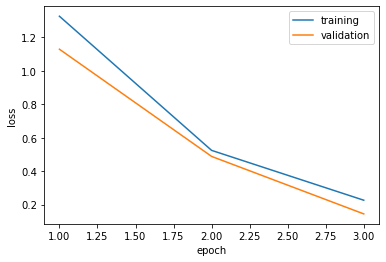

In [25]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### Evaluate model performance

We can evaluate further using a confusion matrix, not that it is entirely ecessary in this case.

Getting predictions from test set...


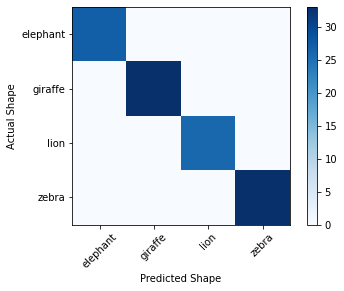

In [26]:
from sklearn.metrics import confusion_matrix

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data and convert to numpy arrays for use with SciKit-Learn
print("Getting predictions from test set...")
truelabels = []
predictions = []
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

## Save the model

In [18]:
# Save the model weights
model_file = 'animal_classifier.pt'
torch.save(model.state_dict(), model_file)
del model
print('model saved as', model_file)

model saved as animal_classifier.pt
